<a href="https://colab.research.google.com/github/1gnacio/orgadatos-collab-tp2/blob/ignacio-tp2-punto1-hastanaivebayes/TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico 2 : NLP + Árboles de Decisión

Fecha máxima de entrega: *Lunes 30 de mayo.*

---



In [96]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st

## Parte 1 - Análisis de sentimientos

En esta primera parte se trabajará sobre un conjunto de datos de comercio electrónico de ropa de mujer que contiene reseñas escritas por los clientes. El objetivo es realizar un análisis de sentimientos para clasificar las reseñas como positivas o negativas.


### 1. Exploración, preprocesamiento y transformación de datos

a. Realizar Exploración de datos, describiendo las características de los mismos. 

b. Realizar las tareas de limpieza y transformación de datos que sean necesarias.

c. Construir la variable objetivo considerando al atributo Rating de la siguiente forma:
 * Negativo: 1-2-3
 * Positivo: 4-5


#### Exploración del dataset

In [97]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [98]:
#data = pd.read_csv('/content/drive/MyDrive/Organización de datos/Material/Womens Clothing E-Commerce Reviews.csv')
import io
#data = pd.read_csv(io.BytesIO(uploaded['Womens Clothing E-Commerce Reviews.csv']))
data = pd.read_csv('/content/drive/MyDrive/Recursos TP2/Womens Clothing E-Commerce Reviews.csv')
data

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...,...
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


Como hay una columna que duplica los índices la eliminamos.

In [99]:
data.drop(columns=['Unnamed: 0'], inplace=True)
data

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...
23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


Este dataset tiene 10 variables distintas, en donde cada fila presenta una crítica (positiva o negativa) a una prenda de ropa.

| _Variable_              	| _Tipo_                	| _Descripción_                                                   	|
|-------------------------	|-----------------------	|-----------------------------------------------------------------	|
| Clothing ID             	|                       	| ID de la prenda                                                 	|
| Age                     	| Cuantitativa continua 	| Edad de la persona que hace la crítica                          	|
| Title                   	| Cualitativa nominal   	| Título de la crítica                                            	|
| Review Text             	| Cualitativa           	| Texto de la crítica                                             	|
| Rating                  	| Cuantitativa discreta 	| Puntuación de 1 a 5                                             	|
| Recommended IND         	| Cualitativa binaria   	|                                                                 	|
| Positive Feedback Count 	| Cuantitativa discreta 	|                                                                 	|
| Division Name           	| Cualitativa nominal   	| División a la que pertenece la prenda                           	|
| Department Name         	| Cualitativa nominal   	| Departamento (dentro de la división) al que pertenece la prenda 	|
| Class Name              	| Cualitativa nominal   	| Clase (dentro del departamento) a la que pertenece la prenda    	|

Sobre las variables cualitativas, vemos para _Division Name_ y _Department Name_ la cantidad de registros sobre cada una.

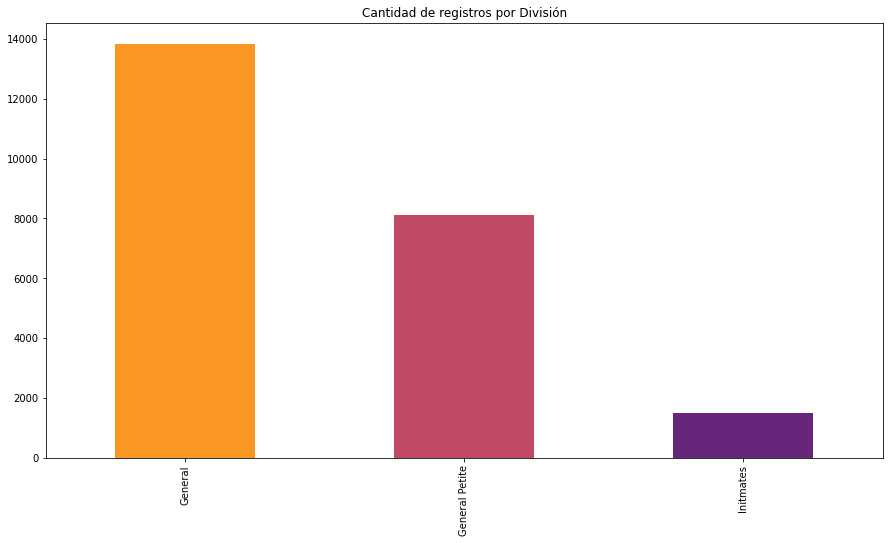

In [100]:
colores = sns.color_palette("inferno_r", 3)
data['Division Name'].value_counts().plot.bar(alpha=0.9,color=colores, figsize=(15,8), title='Cantidad de registros por División')
plt.show()

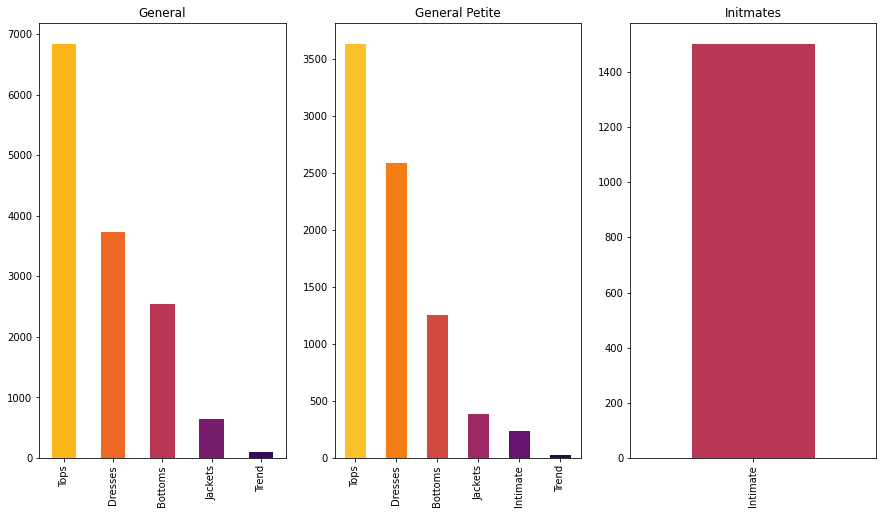

In [101]:
fig, axarr=plt.subplots(nrows=1, ncols=3, figsize=(15, 8))
data[data['Division Name']=='General']['Department Name'].value_counts().plot.bar(title='General', color=sns.color_palette("inferno_r", 5), ax=axarr[0])
data[data['Division Name']=='General Petite']['Department Name'].value_counts().plot.bar(title='General Petite', color=sns.color_palette("inferno_r", 6), ax=axarr[1])
data[data['Division Name']=='Initmates']['Department Name'].value_counts().plot.bar(title='Initmates', color=sns.color_palette("inferno_r", 1), ax=axarr[2])
plt.show()

Respecto a _Class Name_ hacemos una suma de la cantidad de apariciones agrupado por departamento y división.

In [102]:
data.groupby(['Division Name', 'Department Name'])['Class Name'].value_counts()

Division Name   Department Name  Class Name    
General         Bottoms          Pants              835
                                 Jeans              787
                                 Skirts             601
                                 Shorts             317
                                 Casual bottoms       2
                Dresses          Dresses           3730
                Jackets          Jackets            397
                                 Outerwear          248
                Tops             Knits             3259
                                 Blouses           1993
                                 Sweaters           900
                                 Fine gauge         685
                Trend            Trend               96
General Petite  Bottoms          Pants              553
                                 Jeans              360
                                 Skirts             344
                Dresses          Dresses           2589


Para las variables cuantitavivas realizamos un histograma para la variable _Age_ y uno gráfico de barras para _Rating_.

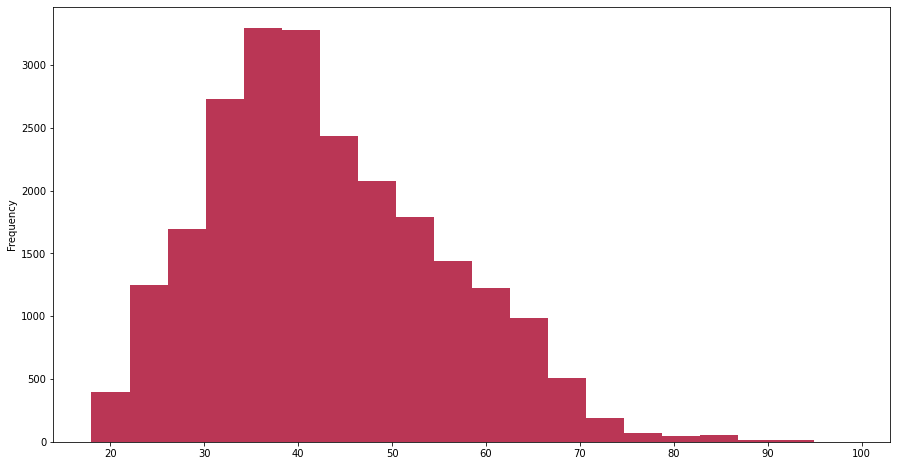

In [103]:
data['Age'].plot.hist(bins=20, figsize=(15,8), color=['#BA3655'])
plt.show()

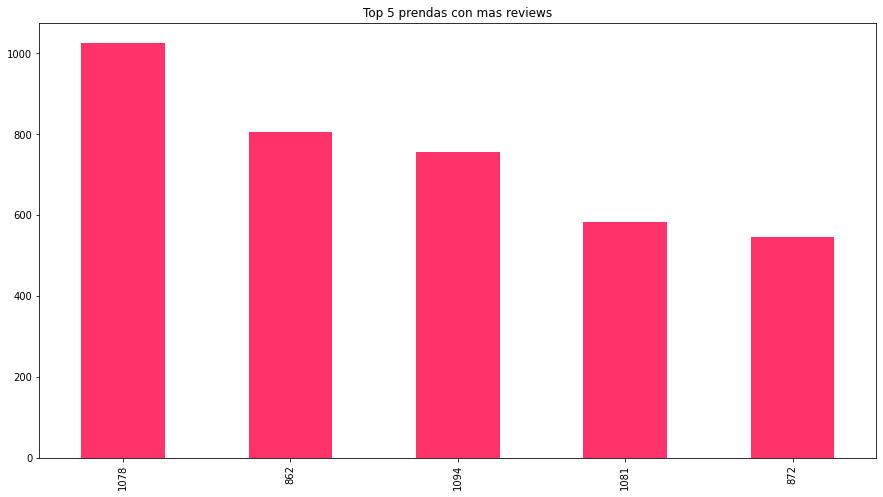

In [104]:
ax = data['Clothing ID'].value_counts().sort_values(ascending=False).head(5).plot.bar(figsize=(15,8), color=['#FF336A'])
ax.set_title('Top 5 prendas con mas reviews')
plt.show()

#### Limpieza y transformación

##### Comenzamos por las variables cuantitativas



Vemos la cantidad de valores nulos (NaN) en el dataset.

In [105]:
data.isna().sum()

Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

Para éste tipo de variable no hay datos nulos, revisamos que no haya datos nulos (distintos de NaN, como 0 por ejemplo) u outliers. Para eso vemos las medidas de resumen de las variables cuantitativas del dataset.

In [106]:
cuantitativas = data[['Age', 'Rating', 'Positive Feedback Count']]
cuantitativas.describe()

,Age,Rating,Positive Feedback Count
count,23486.000000,23486.000000,23486.000000
mean,43.198544,4.196032,2.535936
std,12.279544,1.110031,5.702202
min,18.000000,1.000000,0.000000
25%,34.000000,4.000000,0.000000
50%,41.000000,5.000000,1.000000
75%,52.000000,5.000000,3.000000
max,99.000000,5.000000,122.000000


Por el lado de los valores mínimos no se ve nada raro, por el lado de los máximos sí. Para sacar los outliers vamos a realizar un análisis univariado calculando el z_score.

In [134]:
# z_score edad
data['z_Age']=st.zscore(data.Age)

# z_score modificado Rating
data['z_Rating']=st.zscore(data.Rating)

# z_score modificado Positive Feedback Count
data.rename(columns={'Positive Feedback Count':'Positive_Feedback_Count'}, inplace=True)
data['z_PFC']=st.zscore(data.Positive_Feedback_Count)

data[['Age', 'Rating', 'Positive_Feedback_Count', 'z_Age', 'z_Rating', 'z_PFC']]

,Age,Rating,Positive_Feedback_Count,z_Age,z_Rating,z_PFC
0,33,4,0,-0.834064,-0.164111,-0.454732
1,34,5,4,-0.752947,0.732046,0.236438
2,60,3,0,1.356082,-1.060269,-0.454732
3,50,5,0,0.544917,0.732046,-0.454732
4,47,5,6,0.301567,0.732046,0.582022
...,...,...,...,...,...,...
23481,34,5,0,-0.752947,0.732046,-0.454732
23482,48,3,0,0.382684,-1.060269,-0.454732
23483,31,3,1,-0.996297,-1.060269,-0.281940
23484,28,3,2,-1.239646,-1.060269,-0.109147


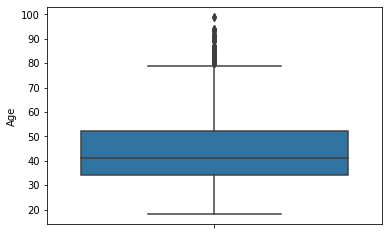

In [108]:
sns.boxplot(y=data['Age'])

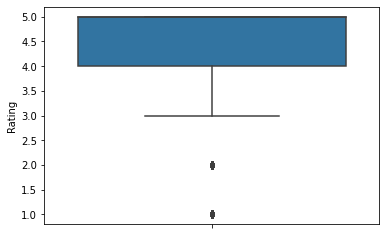

In [109]:
sns.boxplot(y=data['Rating'])

In [110]:
data['Rating'].value_counts()

5    13131
4     5077
3     2871
2     1565
1      842
Name: Rating, dtype: int64

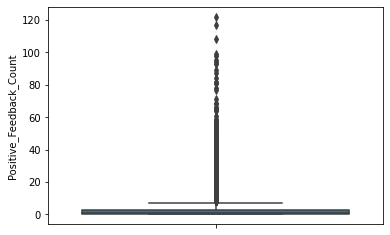

In [111]:
sns.boxplot(y=data['Positive_Feedback_Count'])

Verifico para cada variable que `abs(z_score) < 3`. Revisamos los outliers para cada variable.



In [141]:
data[abs(data['z_Age']) >= 3][['Age', 'z_Age']].sort_values(by='z_Age', ascending=False)

,Age,z_Age
8327,99,4.519626
11545,99,4.519626
6543,94,4.114043
18563,94,4.114043
18036,94,4.114043
...,...,...
21719,81,3.059529
22085,81,3.059529
5469,81,3.059529
17611,81,3.059529


In [142]:
data[abs(data['z_Rating']) >= 3][['Rating', 'z_Rating']]

,Rating,z_Rating


In [146]:
data[abs(data['z_PFC']) >= 3][['Positive_Feedback_Count', 'z_PFC']].sort_values(by='Positive_Feedback_Count', ascending=False)

,Positive_Feedback_Count,z_PFC
7218,122,20.625945
1294,117,19.761983
7765,108,18.206851
19094,99,16.651719
13210,98,16.478927
...,...,...
2467,20,3.001117
7630,20,3.001117
13522,20,3.001117
21634,20,3.001117


El dataset en total tiene 23486 registros, de los cuales 529 (como mucho, ya que puede haber algún repetido entre los outliers de _Age_ y _Positive Feedback Count_) son outliers según el cálculo del z_score, lo que representa sólo un 2.25%. Como la edad y el positive feedback no impactan en la validez de la review, los consideramos para el analisis.

Finalmente, eliminamos las columnas agregadas.

In [115]:
data.drop(columns=['z_Age', 'z_Rating', 'z_PFC'], inplace=True)

##### Seguimos por las cualitativas

Vemos la cantidad de valores nulos (NaN) en el dataset.

In [116]:
data.isna().sum()

Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive_Feedback_Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

Empezamos por llenar la división, departamento y clase.

In [117]:
data.groupby(['Class Name'])['Department Name'].value_counts()

Class Name      Department Name
Blouses         Tops               3097
Casual bottoms  Bottoms               2
Chemises        Intimate              1
Dresses         Dresses            6319
Fine gauge      Tops               1100
Intimates       Intimate            154
Jackets         Jackets             704
Jeans           Bottoms            1147
Knits           Tops               4843
Layering        Intimate            146
Legwear         Intimate            165
Lounge          Intimate            691
Outerwear       Jackets             328
Pants           Bottoms            1388
Shorts          Bottoms             317
Skirts          Bottoms             945
Sleep           Intimate            228
Sweaters        Tops               1428
Swim            Intimate            350
Trend           Trend               119
Name: Department Name, dtype: int64

In [118]:
data.groupby(['Class Name'])['Division Name'].value_counts()

Class Name      Division Name 
Blouses         General           1993
                General Petite    1104
Casual bottoms  General              2
Chemises        Initmates            1
Dresses         General           3730
                General Petite    2589
Fine gauge      General            685
                General Petite     415
Intimates       Initmates          154
Jackets         General            397
                General Petite     307
Jeans           General            787
                General Petite     360
Knits           General           3259
                General Petite    1584
Layering        Initmates          146
Legwear         Initmates          165
Lounge          Initmates          458
                General Petite     233
Outerwear       General            248
                General Petite      80
Pants           General            835
                General Petite     553
Shorts          General            317
Skirts          General          

En base a esto hacemos un diccionario para llenar los departamentos, ya que no hay repetidos.

In [119]:
dict_dep = {'Blouses': 'Tops', 'Casual bottoms': 'Bottoms', 'Chemises': 'Intimate', 'Dresses': 'Dresses', 'Fine gauge': 'Tops', 'Intimates': 'Intimate', \
            'Jackets': 'Jackets', 'Jeans': 'Bottoms', 'Knits': 'Tops', 'Layering': 'Intimate', 'Legwear': 'Intimate', 'Lounge': 'Intimate', 'Outerwear': 'Jackets', \
            'Pants': 'Bottoms', 'Shorts': 'Bottoms', 'Skirts': 'Bottoms', 'Sleep': 'Intimate', 'Sweaters': 'Tops', 'Swim': 'Intimate', 'Trend': 'Trend'}

In [120]:
dict_dep.keys()

dict_keys(['Blouses', 'Casual bottoms', 'Chemises', 'Dresses', 'Fine gauge', 'Intimates', 'Jackets', 'Jeans', 'Knits', 'Layering', 'Legwear', 'Lounge', 'Outerwear', 'Pants', 'Shorts', 'Skirts', 'Sleep', 'Sweaters', 'Swim', 'Trend'])

In [121]:
data.isna().sum()

Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive_Feedback_Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

In [122]:
data.loc[data['Class Name'].isna()]

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive_Feedback_Count,Division Name,Department Name,Class Name
9444,72,25,My favorite socks!!!,"I never write reviews, but these socks are so ...",5,1,0,NaN,NaN,NaN
13767,492,23,So soft!,I just love this hoodie! it is so soft and com...,5,1,1,NaN,NaN,NaN
13768,492,49,Wardrobe staple,Love this hoodie. so soft and goes with everyt...,5,1,0,NaN,NaN,NaN
13787,492,48,NaN,NaN,5,1,0,NaN,NaN,NaN
16216,152,36,Warm and cozy,"Just what i was looking for. soft, cozy and warm.",5,1,0,NaN,NaN,NaN
16221,152,37,Love!,I am loving these. they are quite long but are...,5,1,0,NaN,NaN,NaN
16223,152,39,"""long and warm""",These leg warmers are perfect for me. they are...,5,1,0,NaN,NaN,NaN
18626,184,34,Nubby footless tights,"These are amazing quality. i agree, size up to...",5,1,5,NaN,NaN,NaN
18671,184,54,New workhorse,These tights are amazing! if i care for them w...,5,1,0,NaN,NaN,NaN
20088,772,50,Comfy sweatshirt!,This sweatshirt is really nice! it's oversize...,5,1,0,NaN,NaN,NaN


In [123]:
len(aux)

22943

In [124]:
len(data)

23486

Encontramos 14 registros que no tienen asociado una prenda de vestir (Class name), departamento (Department Name) ni tipo de prenda (Division Name). Al no ser una cantidad significativa (14 sobre 23 mil) no los vamos a considerar para el analisis.

In [125]:
data.drop(index= data[data['Class Name'].isna()].index, inplace=True)
len(data)

23472

Para los casos en que Title o Review Text son nulos, tampoco los vamos a considerar en el analisis. Si uno de los dos es exclusivamente nulo, reemplazamos el valor NaN con su variante no nula. 

In [126]:
len(data[(data['Title'].isna()) & (data['Review Text'].isna())])

843

In [127]:
data.drop(index= data[(data['Title'].isna()) & (data['Review Text'].isna())].index, inplace=True)
len(data)

22629

In [128]:
data['Review Text'].fillna(data['Title'], inplace=True)
data['Title'].fillna(data['Review Text'], inplace=True)

In [129]:
data.loc[data['Review Text'].str.len().sort_values().index]

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive_Feedback_Count,Division Name,Department Name,Class Name
7785,820,50,Another beautiful white top,Great fit,5,1,0,General Petite,Tops,Blouses
7236,877,41,Comfy cozy!,Comfy cozy!,4,1,0,General,Tops,Knits
8742,952,48,Beautiful unique sweater,I love birds,4,1,0,General,Tops,Sweaters
859,886,27,Great style!,Great style!,5,1,1,General Petite,Tops,Knits
15653,1089,29,Perfect bride dress,Fits perfect.,5,1,0,General,Dresses,Dresses
...,...,...,...,...,...,...,...,...,...,...
22010,909,53,Never been more disappointed...,"Retailer consistently provides unique, sophist...",1,0,5,General Petite,Tops,Fine gauge
1974,1092,50,Love this dress,One of the things i love most about this dress...,5,1,1,General Petite,Dresses,Dresses
22936,1107,48,Love it!,I love this cotton weave shift dress. it is su...,5,1,1,General Petite,Dresses,Dresses
19304,1103,91,I don't understand this dress,I have been continually disappointed in retail...,1,0,3,General,Dresses,Dresses


Observamos que las Review Text son resenias validas para cada prenda, y en donde el Title o el Review Text eran nulos, se reemplazo por su contraparte no nula.

In [130]:
data.loc[data['Title'].str.len().sort_values().index]

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive_Feedback_Count,Division Name,Department Name,Class Name
15671,862,30,<3,I ordered this top in rose. (the color is actu...,5,1,0,General,Tops,Knits
20781,1078,29,Eh,"I love the colors of the teal dress, but i wis...",3,0,8,General Petite,Dresses,Dresses
22885,895,33,No,"Bummer, i loved the lacy bell arms and everyth...",1,0,2,General Petite,Tops,Fine gauge
11778,1022,38,Ag,Awesome jeans. cute and comfortable! size down...,5,1,0,General,Bottoms,Jeans
2876,573,34,Ok,I was so excited to receive this in the mail a...,3,0,4,General Petite,Trend,Trend
...,...,...,...,...,...,...,...,...,...,...
126,1133,71,I read the previous reviews and had hoped that...,I read the previous reviews and had hoped that...,4,1,0,General,Jackets,Outerwear
13284,936,67,I love this sweater! i was nervous after readi...,I love this sweater! i was nervous after readi...,5,1,0,General Petite,Tops,Sweaters
9157,907,47,I had been eyeing this sweater since it came i...,I had been eyeing this sweater since it came i...,5,1,0,General,Tops,Fine gauge
13255,1078,30,Beautiful dress; i ended up getting it in both...,Beautiful dress; i ended up getting it in both...,5,1,0,General,Dresses,Dresses


Observamos tambien que los titulos con pocos caracteres, corresponden a resernias validas para cada prenda.

In [131]:
data['Clothing ID'].value_counts()

1078    987
862     778
1094    735
1081    561
872     519
       ... 
27        1
246       1
557       1
65        1
522       1
Name: Clothing ID, Length: 1172, dtype: int64

#### Construccion de variable objetivo en funcion del Rating

Construimos la variable a analizar en base al Rating, donde los ratings entre 1-3 van a ser reviews negativas y entre 4-5 reviews positivas. Llamamos a nuestra variable objetivo _Positive_review_ que toma valores 0 (review negativa) y 1 (review positiva).

In [152]:
data['Positive_review'] = data['Rating']
data.loc[data['Rating'] < 4, 'Positive_review'] = 0
data.loc[data['Rating'] >= 4, 'Positive_review'] = 1

data[['Rating', 'Positive_review']]

,Rating,Positive_review
0,4,1
1,5,1
2,3,0
3,5,1
4,5,1
...,...,...
23481,5,1
23482,3,0
23483,3,0
23484,3,0


In [153]:
data.value_counts(['Positive_review'])

Positive_review
1                  17436
0                   5193
dtype: int64

### 2. Generación y evaluación de modelos 

a. Dividir el conjunto de datos en un 70-30, en donde el 70% de los datos se utilizarán para
entrenar el modelo y el 30% restante para validarlo. 

b. Entrenar los siguientes algoritmos tal que a partir del texto en el campo “Review Text”, pueda clasificar correctamente la crítica como positiva o negativa.
 * Naive Bayes
 * Regresión logística
 * Árboles de decisión
 * Random Forest  

c. Evaluar todos los clasificadores utilizando las métricas, precisión, recall y F1-Score.

d. Seleccionar el modelo con mejor desempeño y evaluarlo utilizando las 5 clases del
atributo Rating en lugar de la clase binaria

#### Generacion de conjunto de prueba y conjunto de entrenamiento

Separamos el dataset original en dos subsets, donde uno representa el 70% de los registros que van a ser utilizados para entrenar el modelo y el otro 30% restante se utilizara para prueba.

In [177]:
from sklearn.model_selection import train_test_split

data_cpy = data.copy()
data_cpy.rename(columns={'Review Text':'Review_Text'}, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(data_cpy.Review_Text, data_cpy.Positive_review, test_size=0.30, random_state=25, shuffle=True)


In [178]:
y_train.value_counts()

1    12241
0     3599
Name: Positive_review, dtype: int64

In [179]:
y_test.value_counts()

1    5195
0    1594
Name: Positive_review, dtype: int64

#### Generacion de modelos

A continuacion generamos los siguientes modelos:



 * Naive Bayes
 * Regresión logística
 * Árboles de decisión
 * Random Forest  



##### Naive bayes

In [181]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X_train)
corpus = vectorizer.get_feature_names_out()

transformer = TfidfTransformer(smooth_idf=True)
transformer.fit_transform(X.toarray()).toarray()

vectorizer = TfidfVectorizer()
vectorizer.fit_transform(corpus)

#Usando el make_pipeline, creamos un modelo que
# automáticamente aplica TfidfVectorizer y luego lo pasa a Bayes.
# Entonces este modelo “es como si” trabajase directamente con el
# texto en lenguaje natural.

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

#Entrenamos el modelo
model.fit(X_train, y_train)

#hacemos predicciones en el conjunto de prueba
predicted_categories = model.predict(X_test)

print("La precision es {}".format(accuracy_score(y_test,
predicted_categories)))

print("El recall es {}".format(recall_score(y_test,
predicted_categories)))

print("F1 es {}".format(f1_score(y_test,
predicted_categories)))


La precision es 0.7775813816467816
El recall es 0.9994225216554379
F1 es 0.873045232890533


### 3. Conclusiones
Extraer conclusiones a partir de los análisis realizados en los puntos anteriores, y
justificar cada conclusión.

**Naive bayes**

La precision es 0.7775813816467816  
El recall es 0.9994225216554379  
F1 es 0.873045232890533  